This notebook wrangles New York, NY census data from the American Community Survey website. The csv contains information abbout:

- total households  

- household income (100k-149k, 150k-199k, 200k over )

- public transportation commuting 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
income_data = 'household_income.csv'
commute_data = 'commute.csv'

In [3]:
income_df = pd.read_csv(income_data,
                       usecols = ['GEO.display-label', 'HC01_EST_VC01', 'HC01_EST_VC09', 'HC04_EST_VC10','HC01_EST_VC11']
                       )

commute_df = pd.read_csv(commute_data, 
                         usecols = ['GEO.display-label', 'HC01_EST_VC10']
                        )
dfs = [income_df, commute_df]

for df in dfs:
    df.drop(0, inplace=True)
    df.reset_index(drop=True)

In [4]:
income_df.rename(columns = { 'GEO.display-label': 'zip_code',
                            'HC01_EST_VC01': 'total_households',
                           'HC01_EST_VC09': 'percent_100_149k',
                           'HC04_EST_VC10': 'percent_150_199k',
                           'HC01_EST_VC11': 'percent_200k_over'},
                 inplace=True
                )

In [5]:
commute_df.rename(columns = {'GEO.display-label': 'zip_code',
                            'HC01_EST_VC10': 'percent_public_trans'},
                 inplace = True
                 )

In [6]:
# let's format the zipcode column
income_df['zip_code'] = income_df['zip_code'].map(lambda x : str(x)[-5:])

In [7]:
commute_df['zip_code'] = commute_df['zip_code'].map(lambda x : str(x)[-5:])

In [8]:
#in order to perform operations in the numerical columns we need to convert them to float and/or integers 
income_df['zip_code'] = income_df['zip_code'].apply(int)
income_df['total_households'] = income_df['total_households'].apply(float)

In [9]:
percents = {
            'percent_100_149k': 'total_100_149k',
            'percent_150_199k': 'total_150_199k',
            'percent_200k_over': 'total_200k_over'
           }

In [10]:
for percent in percents:
    income_df.loc[income_df[percent] == '-', percent] = 0

In [11]:
income_df['total_households'] = income_df['total_households'].apply(float)

for percent in percents:
    income_df[percent] = income_df[percent].apply(float)

In [12]:
income_df.dtypes

zip_code               int64
total_households     float64
percent_100_149k     float64
percent_150_199k     float64
percent_200k_over    float64
dtype: object

In [13]:
commute_df.loc[commute_df['percent_public_trans'] == '-'] = 0

In [14]:
commute_df['zip_code'] = commute_df['zip_code'].apply(int)
commute_df['percent_public_trans'] = commute_df['percent_public_trans'].apply(float)

In [15]:
# we are going to be analyzing the data by zip code so to make the analysis easier let's index it by that column
income_df = income_df.set_index('zip_code')

In [16]:
commute_df = commute_df.set_index('zip_code')

In [17]:
consolidated_df = income_df.join(commute_df)

In [18]:
consolidated_df = consolidated_df.reset_index()
#consolidated_df.head()

In [19]:
consolidated_df.sort_values(by = ["percent_public_trans","percent_200k_over"], ascending = False).head(10)

,zip_code,total_households,percent_100_149k,percent_150_199k,percent_200k_over,percent_public_trans
878,12784,12.0,0.0,0.0,0.0,100.0
40,10044,4820.0,18.6,2.0,19.1,83.2
352,11430,0.0,0.0,0.0,0.0,82.8
268,11109,2891.0,23.4,13.0,32.3,81.9
25,10026,15401.0,12.2,6.0,10.6,78.3
30,10031,22274.0,10.3,2.4,4.2,76.9
38,10039,11153.0,8.1,1.0,2.1,76.6
262,11101,12474.0,13.8,7.5,11.9,76.2
293,11226,36677.0,11.0,2.2,3.5,73.6
87,10454,13085.0,4.2,0.1,0.7,73.0


In [20]:
# remove incorrect zipcode from dataframe
consolidated_df['zip_code'] = consolidated_df['zip_code'].apply(lambda x: x if str(x)[0]=='1' else 0)
consolidated_df = consolidated_df[consolidated_df['zip_code'] != 0]
consolidated_df.head()

,zip_code,total_households,percent_100_149k,percent_150_199k,percent_200k_over,percent_public_trans
2,10001,12347.0,15.7,6.2,22.4,46.1
3,10002,33461.0,9.2,4.0,6.4,53.8
4,10003,26699.0,14.4,10.6,26.8,53.1
5,10004,1587.0,25.4,14.0,33.0,59.3
6,10005,4239.0,22.8,16.0,37.5,64.0


### Visualization

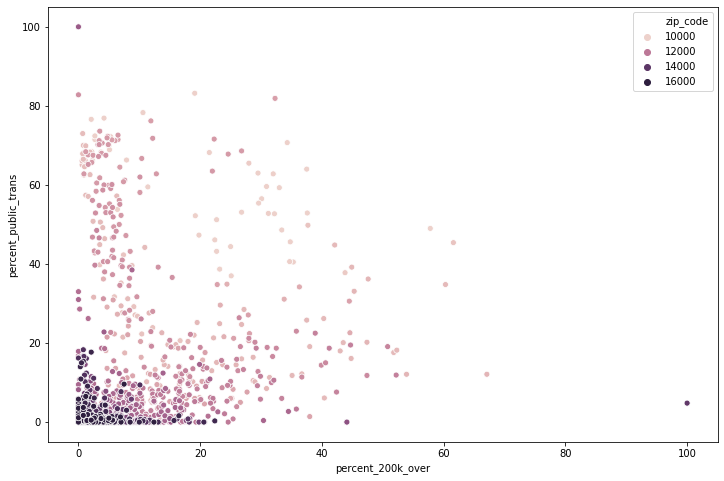

In [21]:
import seaborn as sns 

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

sns.scatterplot(x="percent_200k_over", y="percent_public_trans", hue = "zip_code", data=consolidated_df)

    
fig.savefig('public_trans_200k.png')

### Save census df to pickle

In [22]:
consolidated_df.to_pickle('census_nyc.pkl')